## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [3]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [6]:
# load the data - it is available open source and online

#data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# # display data
# data.head()

In [ ]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [ ]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [ ]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [ ]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [ ]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [ ]:
# save the data set

data.to_csv('titanic.csv', index=False)

In [7]:
data = pd.read_csv("titanic.csv")

## Data Exploration

### Find numerical and categorical variables

In [8]:
target = 'survived'

In [9]:
vars_num = ['age','fare','sibsp', 'parch']

vars_cat = ['pclass', 'sex', 'cabin','embarked', 'title']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 4
Number of categorical variables: 5


### Find missing values in variables

In [10]:
# first in numerical variables

data.loc[data[vars_num].isnull().any(axis=1),vars_num]

,age,fare,sibsp,parch
15,NaN,25.9250,0,0
37,NaN,26.5500,0,0
40,NaN,39.6000,0,0
46,NaN,31.0000,0,0
59,NaN,27.7208,0,0
...,...,...,...,...
1293,NaN,8.0500,0,0
1297,NaN,7.2500,0,0
1302,NaN,7.2250,0,0
1303,NaN,14.4583,0,0


In [11]:
# now in categorical variables

data.loc[data[vars_cat].isnull().any(axis=1),vars_cat]

,pclass,sex,cabin,embarked,title
9,1,male,NaN,C,Mr
13,1,female,NaN,S,Miss
15,1,male,NaN,S,Mr
23,1,female,NaN,C,Miss
25,1,male,NaN,C,Mr
...,...,...,...,...,...
1304,3,female,NaN,C,Miss
1305,3,female,NaN,C,Miss
1306,3,male,NaN,C,Mr
1307,3,male,NaN,C,Mr


### Determine cardinality of categorical variables

In [12]:
data[vars_cat].nunique()

pclass        3
sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

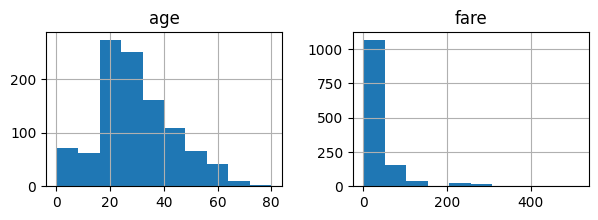

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(7, 2)) #necessary line
for ax, col in zip(axs.flatten(), vars_num):
    data.hist(column=col, ax=ax)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [30]:
X_train["cabin"] = X_train["cabin"].str[0]
X_test["cabin"] = X_test["cabin"].str[0]

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [31]:
X_train[vars_num] = X_train[vars_num].fillna(X_train[vars_num].median())
X_test[vars_num] = X_test[vars_num].fillna(X_test[vars_num].median())

### Replace Missing data in categorical variables with the string **Missing**

In [32]:
X_train = X_train.fillna('Missing')
X_test = X_test.fillna('Missing')

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [33]:
X_train["pclass"].value_counts(normalize=True)

pclass
3    0.546323
1    0.249284
2    0.204394
Name: proportion, dtype: float64

In [34]:
for col in vars_cat:
    freq = X_train[col].value_counts(normalize=True)

    rare_indexes = freq[freq < 0.05].index

    X_train[col] = X_train[col].replace(rare_indexes,"Other")
    X_test[col] = X_test[col].replace(rare_indexes,"Other")


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [35]:
X_train = pd.get_dummies(X_train,columns=vars_cat,drop_first=True)
X_test = pd.get_dummies(X_test,columns=vars_cat,drop_first=True)

### Scale the variables

- Use the standard scaler from Scikit-learn

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[vars_num] = scaler.fit_transform(X_train[vars_num])
X_test[vars_num] = scaler.fit_transform(X_test[vars_num])

In [40]:
X_train

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,cabin_Missing,cabin_Other,embarked_Other,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Other
1118,-0.370162,-0.478911,-0.455423,-0.504782,False,True,True,True,False,False,False,True,True,False,False
44,0.904029,-0.478911,-0.455423,1.971555,False,False,False,False,True,False,False,False,False,False,False
1072,-0.131251,-0.478911,-0.455423,-0.508533,False,True,True,True,False,False,True,False,True,False,False
1130,-0.927621,-0.478911,-0.455423,-0.507717,False,True,False,True,False,False,False,True,False,False,False
574,-0.051614,0.434422,-0.455423,-0.248980,True,False,True,True,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-2.347810,0.434422,1.910970,-0.257295,False,True,False,True,False,False,False,True,False,False,False
835,-0.131251,-0.478911,-0.455423,-0.502337,False,True,True,True,False,False,False,True,True,False,False
1216,-0.131251,-0.478911,-0.455423,-0.508533,False,True,False,True,False,False,True,False,False,False,False
559,-0.768347,-0.478911,-0.455423,0.059156,True,False,False,True,False,False,False,True,False,False,False


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [42]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)

model.fit(X_train,y_train)

preds = model.predict(X_train)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [45]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(preds,y_train))

print(accuracy_score(preds,y_train))

0.8008166006787332
0.8108882521489972


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

On a fait une regression logistique

l'importance représente les poids des variables dans la fonction, c'est de l'étude de correlation. Plus la valeur est basse, plus c'est anti correlé à survivre ( à y_test = 1)
B0 + B1 X1 + B2 X2 + ... pour chaque variable, X représentant la valeur de la variable, X son poid

B0 est l'intercept, ici 1.87, B1 est 1.34, X1 est la valeur de title_MR (1 ou 0 car catégorie apres one hot encoding)

si on prend que title_Mr et sex_male on a log odds= 1.87 − 1.34 × 1 − 1.18 × 1=-0,65 
on peut établir la proba de survivre : e^odd / (1+e^odd) = 0.52/(1+0.52) = 0,34


ICI, en réalité, sex_male et title_Mr sont fortement corélée ( a voir dans la matrice de corrélation tout en bas), ce qui gène le modèle car il a deux fois les meme variables. 
Il faudrait supprimer une des deux variables

In [58]:
importance = pd.Series(model.coef_.ravel())
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=False)
importance

cabin_Other       0.781109
title_Mrs         0.618762
fare              0.163172
title_Other       0.151898
embarked_Other    0.077385
parch            -0.162703
pclass_2         -0.238067
cabin_Missing    -0.252513
age              -0.354608
embarked_Q       -0.392596
sibsp            -0.422944
embarked_S       -0.578064
pclass_3         -1.043782
sex_male         -1.185008
title_Mr         -1.345286
dtype: float64

In [ ]:
beta_0 = model.intercept_[0]


array([1.87562991])

Text(0.5, 1.0, 'Feature Importance')

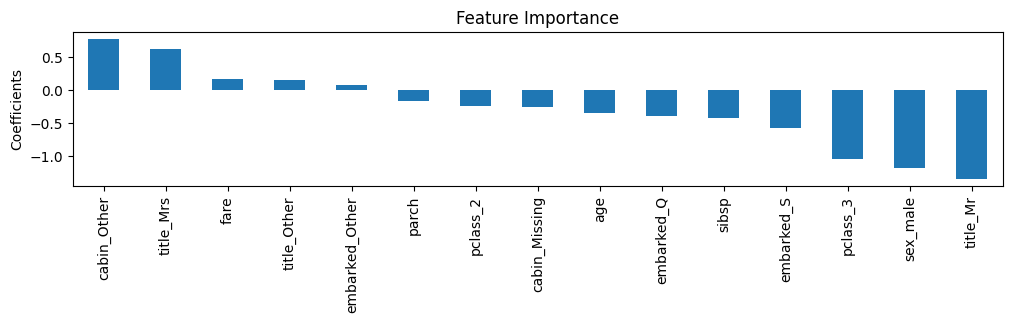

In [59]:
importance.plot.bar(figsize=(12,2))
plt.ylabel('Coefficients')
plt.title('Feature Importance')

In [ ]:
X_train.corr()

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,cabin_Missing,cabin_Other,embarked_Other,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Other
age,1.000000,-0.180355,-0.101668,0.189884,0.000481,-0.318761,0.032362,-0.284866,0.195835,0.070905,-0.042727,-0.050642,0.132671,0.215167,-0.190302
sibsp,-0.180355,1.000000,0.394985,0.171761,-0.054539,0.075465,-0.079007,0.014325,-0.050257,-0.020951,-0.053743,0.081490,-0.210544,0.041533,0.245743
parch,-0.101668,0.394985,1.000000,0.241624,-0.012248,0.013238,-0.211503,-0.040315,0.037453,-0.019924,-0.114344,0.094635,-0.302171,0.218273,0.174247
fare,0.189884,0.171761,0.241624,1.000000,-0.134513,-0.432158,-0.196930,-0.535148,0.292535,0.039605,-0.132469,-0.166088,-0.207558,0.156238,0.041269
pclass_2,0.000481,-0.054539,-0.012248,-0.134513,1.000000,-0.556206,-0.041838,0.167351,-0.090324,-0.022174,-0.129284,0.193766,-0.056529,0.096166,0.026568
pclass_3,-0.318761,0.075465,0.013238,-0.432158,-0.556206,1.000000,0.134506,0.541377,-0.402806,-0.048007,0.244869,0.008800,0.137117,-0.195103,-0.033146
sex_male,0.032362,-0.079007,-0.211503,-0.196930,-0.041838,0.134506,1.000000,0.138338,-0.098306,-0.057484,-0.078090,0.106988,0.874870,-0.572411,0.155747
cabin_Missing,-0.284866,0.014325,-0.040315,-0.535148,0.167351,0.541377,0.138338,1.000000,-0.787461,-0.079363,0.137182,0.155051,0.131831,-0.160924,-0.024281
cabin_Other,0.195835,-0.050257,0.037453,0.292535,-0.090324,-0.402806,-0.098306,-0.787461,1.000000,0.100784,-0.120666,-0.085266,-0.102946,0.110858,0.043541
embarked_Other,0.070905,-0.020951,-0.019924,0.039605,-0.022174,-0.048007,-0.057484,-0.079363,0.100784,1.000000,-0.013979,-0.068393,-0.050291,0.040683,-0.012065
